# TASK #1: IMPORT LIBRARIES AND DATASET

In [1]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset 
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
# Specify training data directory
X_Ray_Directory = 'Train'

In [3]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

In [7]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2)

In [10]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size=40,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='training')

Found 428 images belonging to 4 classes.


In [11]:
validation_generator = image_generator.flow_from_directory(batch_size=40,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='validation')

Found 104 images belonging to 4 classes.


In [16]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [14]:
train_images.shape

(40, 256, 256, 3)

In [15]:
train_labels.shape

(40, 4)

In [17]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]],

In [18]:
# labels Translator 
label_names = {0 : 'Covid-19', 1 : 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# TASK #2: VISUALIZE DATASET

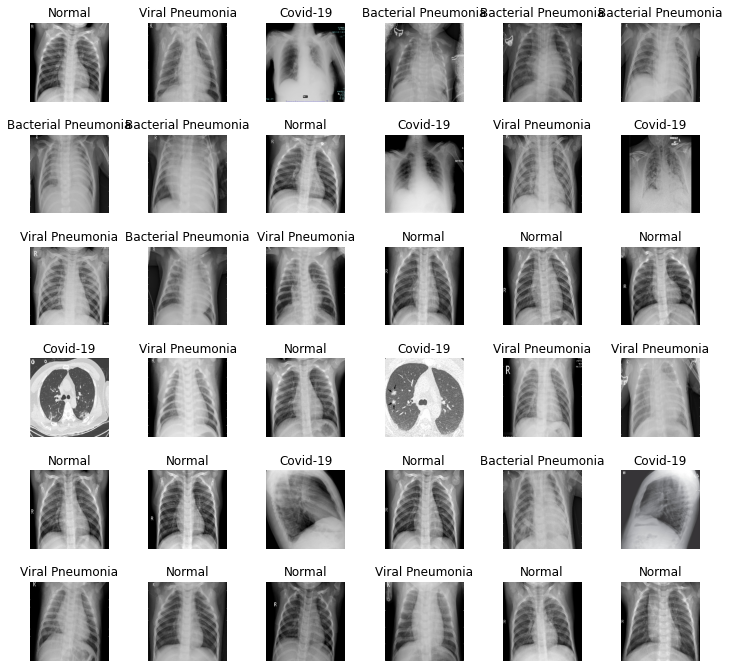

In [26]:
L = 6
W = 6
fig, axes = plt.subplots(L,W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0,L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

# TASK #3: IMPORT MODEL WITH PRETRAINED WEIGHTS

In [29]:
basemodel = ResNet50(weights= 'imagenet', include_top= False, input_tensor= Input(shape = (256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [32]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [33]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False

# TASK #4: BUILD AND TRAIN DEEP LEARNING MODEL

In [44]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4,activation='softmax')(headmodel)

In [45]:
model = Model(inputs = basemodel.input, outputs= headmodel)

In [46]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4), metrics=['accuracy'])

In [47]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience= 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='weights.hdf5',verbose = 1, save_best_only= True)


In [48]:
train_generator = image_generator.flow_from_directory(batch_size=4,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='training')
val_generator = image_generator.flow_from_directory(batch_size=4,directory=X_Ray_Directory,shuffle=True,target_size=(256,256),class_mode='categorical',subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [52]:
history = model.fit_generator(train_generator,epochs = 25, validation_data=val_generator, callbacks=[checkpointer,earlystopping])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9743
Epoch 00001: val_loss did not improve from 3.31913
107/107 [==============================] - 29s 274ms/step - loss: 0.1189 - accuracy: 0.9743 - val_loss: 11.4913 - val_accuracy: 0.2596
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9883
Epoch 00002: val_loss improved from 3.31913 to 2.57290, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


107/107 [==============================] - 30s 284ms/step - loss: 0.0882 - accuracy: 0.9883 - val_loss: 2.5729 - val_accuracy: 0.2981
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.9836
Epoch 00003: val_loss improved from 2.57290 to 0.60615, saving model to weights.hdf5
107/107 [==============================] - 30s 283ms/step - loss: 0.1286 - accuracy: 0.9836 - val_loss: 0.6062 - val_accuracy: 0.7788
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9953
Epoch 00004: val_loss did not improve from 0.60615
107/107 [==============================] - 29s 274ms/step - loss: 0.0162 - accuracy: 0.9953 - val_loss: 0.9169 - val_accuracy: 0.8462
Epoch 5/25
107/107 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.9860
Epoch 00005: val_loss did not improve from 0.60615
107/107 [==============================] - 29s 275ms/step - loss: 0.0806 - accuracy: 0.9860 - val_loss: 0.7373 - val_accura

# TASK #5: EVALUATE TRAINED DEEP LEARNING MODEL

In [55]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Trainin accuracy and loss')

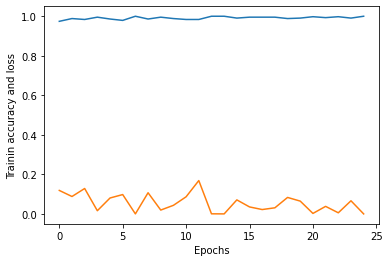

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Trainin accuracy and loss')

Text(0, 0.5, 'Validation loss')

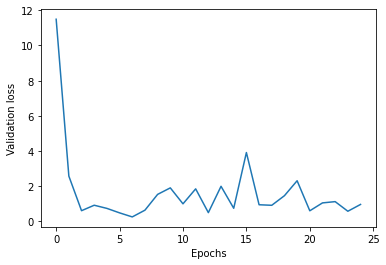

In [60]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')

Text(0, 0.5, 'Validation accuracy')

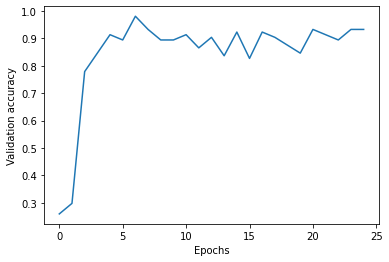

In [61]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')

In [63]:
test_directory = '/content/drive/My Drive/Operations Department/Test'

In [64]:
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(batch_size=40, directory = test_directory, shuffle=True, target_size=(256,256), class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [65]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4,verbose=1)
print('Accuracy {}'.format(evaluate[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


10/10 [==============================] - 3s 7ms/step - loss: 1.5591 - accuracy: 0.8250
Accuracy 0.824999988079071


In [66]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [68]:
score = accuracy_score(original,prediction)
print('Test Accuracy {}'.format(score))

Test Accuracy 0.825


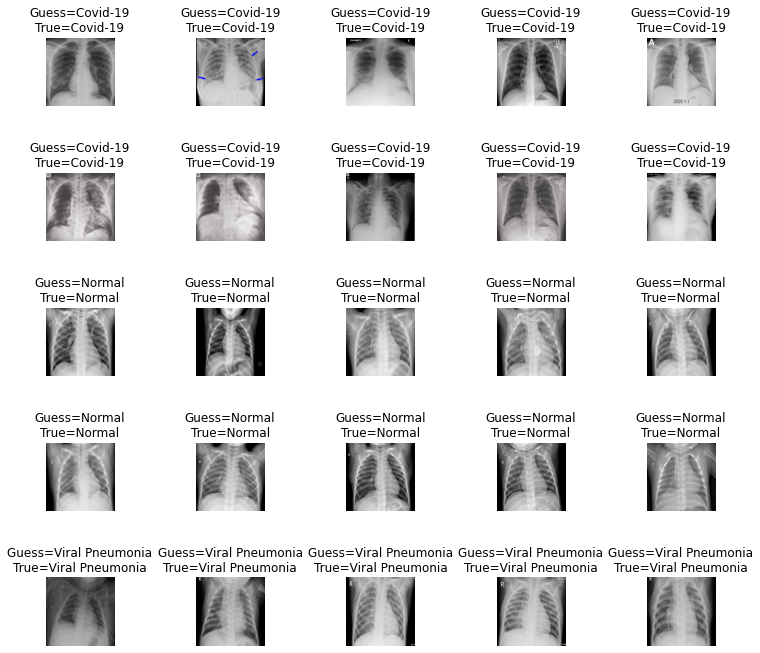

In [69]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [71]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.67      1.00      0.80        10
           2       0.86      0.60      0.71        10
           3       0.88      0.70      0.78        10

    accuracy                           0.82        40
   macro avg       0.85      0.82      0.82        40
weighted avg       0.85      0.82      0.82        40



Text(0.5, 1.0, 'Confusion_matrix')

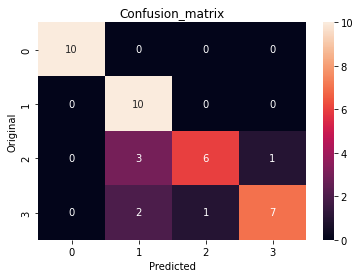

In [74]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
sns.heatmap(cm, annot = True)

plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('Confusion_matrix')